#### Notebook to analyse the distribution of systematics in pixels where Linear and DeepSet deviate

In [1]:
import pandas as pd
import time
import pickle
from models.deep_set.set_dataloader import CCD
import matplotlib.pyplot as plt
import healpy as hp
from astropy.io import fits
import numpy as np


Begin with all steps that are only required once


In [2]:
time_start = time.time()

# For DECAM, BASS, MzLS
with open('../../bricks_data/pixel2ccd_256.pickle', 'rb') as f:
    pixel2ccd_dict = pickle.load(f)
    f.close()

time_end = time.time()
time_passed = time_end - time_start
print()
print(f"{time_passed / 60:.5} minutes ({time_passed:.3} seconds) taken to import the dict")
print()

ccd = CCD()



0.063365 minutes (3.8 seconds) taken to import the dict



Steps:

1. Separate corpus by extreme difference in linear and deep

In [731]:

zscore = lambda x: abs((x - x.median()) / x.std())


In [732]:
# Calculating the Z-value difference between Deep and Linear Models
area = 'des'
gal = 'lrg'


df_test = pd.read_csv(f'results/{area}_complete.csv')
df_test[f'{gal}_LINEAR_VS_DEEP'] = df_test[f'{gal}_lin'] - df_test[f'{gal}_deep']


df_test[f'{gal}_Z'] = df_test[f'{gal}_LINEAR_VS_DEEP'].transform(zscore)

print(df_test[f'{gal}_Z'])

print(df_test.columns)

0        0.634410
1        1.099126
2        0.598832
3        1.274086
4        1.264187
           ...   
86584    0.611190
86585    0.872962
86586    0.749753
86587    1.295438
86588    0.843383
Name: lrg_Z, Length: 86589, dtype: float64
Index(['pixel_id', 'lrg', 'elg', 'qso', 'exposures', 'stellar', 'EBV',
       'airmass', 'ccdskysb_g', 'ccdskysb_r', 'ccdskysb_z', 'exptime_g',
       'exptime_r', 'exptime_z', 'meansky_g', 'meansky_r', 'meansky_z',
       'seeing_g', 'seeing_r', 'seeing_z', 'lrg_lin', 'elg_lin', 'qso_lin',
       'lrg_nn', 'elg_nn', 'qso_nn', 'lrg_deep', 'y_gold_x', 'elg_deep',
       'y_gold_y', 'qso_deep', 'y_gold', 'lrg_LINEAR_VS_DEEP', 'lrg_Z'],
      dtype='object')


In [733]:
# Separating into two corpus

In [734]:
df_diff = df_test[df_test[f'{gal}_Z'] > 2]
df_no_diff = df_test[df_test[f'{gal}_Z'] <= 2]

print(len(df_diff))
print(len(df_no_diff))
print(len(df_diff)/len(df_no_diff))
print(df_diff.head())

3922
82667
0.04744335708323757
     pixel_id  lrg  elg  qso  exposures   stellar       EBV   airmass  \
22     453226   59  138  227   0.293860  0.116279  0.205334  0.392278   
24     685850   44  114  176   0.184211  0.302326  0.502214  0.489615   
114    487004   43  155  184   0.179825  0.100775  0.174979  0.404565   
122    616032   23  112  217   0.236842  0.131783  0.097037  0.616996   
138    622091   35  121  138   0.434211  0.093023  0.098474  0.179945   

     ccdskysb_g  ccdskysb_r  ...      elg_nn      qso_nn   lrg_deep  y_gold_x  \
22     0.523463    0.548335  ...  131.427368  168.429199  32.966816      59.0   
24     0.692145    0.799214  ...  118.098671  179.883362  34.858360      44.0   
114    0.670148    0.743473  ...  131.421738  171.682373  32.803375      43.0   
122    0.684927    0.686109  ...  120.610825  172.882477  32.452549      23.0   
138    0.690534    0.610617  ...  121.208809  152.051834  32.286076      35.0   

       elg_deep  y_gold_y    qso_deep  y_go

2. Identify all CCDs that cover a given pixel in deepset --> use set for that

A. Get all Subpixels for the pixels in the DF
B. Get all CCDs for all these subpixels and create a set



In [735]:
pix_ids_diff = list(df_diff.pixel_id)
ccd_ids_diff = set()

ccds_per_pix = []
for id in pix_ids_diff:
    ccds_per_pix.append(len(pixel2ccd_dict[id]))
    # Iterate through all Pixels with large deviations in prediction
    for elem in pixel2ccd_dict[id]:
        # Add all CCDs to the set --> only unique one's will be retained
        ccd_ids_diff.add(elem)

print(len(ccd_ids_diff))

print("Average CCDs per pixel in diff", sum(ccds_per_pix)/len(ccds_per_pix))

df_diff.exposures = np.array(ccds_per_pix)

424175
Average CCDs per pixel in diff 189.21545130035696


/Users/edgareggert/miniconda3/envs/astro/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [736]:


# Get the available data for the list CCD ids in the deviating set

data_diff = ccd.get_ccds(list(ccd_ids_diff))

print(data_diff)

[['90.0' '1.03' '1.2327176' '22.71432' '0.23975721' 'r']
 ['90.0' '1.11' '1.0752146' '23.70075' '0.09727469' 'g']
 ['90.0' '1.11' '0.99821055' '23.692215' '0.09772081' 'g']
 ...
 ['90.0' '1.03' '1.2294203' '22.713154' '0.239' 'r']
 ['90.0' '1.11' '1.1935278' '22.90093' '0.20443414' 'r']
 ['90.0' '1.03' '1.2465063' '22.71481' '0.23867364' 'r']]


In [737]:
ccd_df_diff = pd.DataFrame(data_diff, columns=['exptime',
                          'airmass',
                          'seeing',
                          'ccdskysb',
                          'meansky',
                           'filter'])


ccd_df_diff.head()

,exptime,airmass,seeing,ccdskysb,meansky,filter
0,90.0,1.03,1.2327176,22.71432,0.23975721,r
1,90.0,1.11,1.0752146,23.70075,0.09727469,g
2,90.0,1.11,0.99821055,23.692215,0.09772081,g
3,90.0,1.11,1.0563654,23.69219,0.097679555,g
4,90.0,1.11,1.0124565,23.690617,0.09783566,g


Repeat the same for the pixels that do not have a large difference

In [738]:
pix_ids_no_diff = list(df_no_diff.pixel_id)
ccd_ids_no_diff = set()

ccds_per_pix = []

for id in pix_ids_no_diff:
    ccds_per_pix.append(len(pixel2ccd_dict[id]))
    # Iterate through all Pixels with large deviations in prediction
    for elem in pixel2ccd_dict[id]:
        # Add all CCDs to the set --> only unique one's will be retained
        ccd_ids_no_diff.add(elem)

print(len(ccd_ids_no_diff))

print("Average CCDs per pixel in no_diff", sum(ccds_per_pix)/len(df_no_diff))
print(df_no_diff.head())
df_no_diff.exposures = np.array(ccds_per_pix)
print(df_no_diff.head())


2957132
Average CCDs per pixel in no_diff 189.67635211148342
   pixel_id  lrg  elg  qso  exposures   stellar       EBV   airmass  \
0    400965   26  127  138   0.210526  0.069767  0.223601  0.516562   
1    689172   33  121  178   0.368421  0.178295  0.065022  0.181972   
2    692796   36  133  199   0.043860  0.147287  0.154664  0.577994   
3    602720   36  134  193   0.302632  0.186047  0.142231  0.594274   
4    558688   41  150  172   0.267544  0.085271  0.091023  0.558270   

   ccdskysb_g  ccdskysb_r  ...      elg_nn      qso_nn   lrg_deep  y_gold_x  \
0    0.550597    0.533751  ...  129.361450  166.119644  32.926765      26.0   
1    0.797624    0.778980  ...  121.209236  151.599442  32.421955      33.0   
2    0.774864    0.771753  ...  124.348053  173.179855  32.834995      36.0   
3    0.736537    0.697164  ...  122.027573  178.936295  32.879860      36.0   
4    0.724642    0.711729  ...  124.595261  175.441879  32.193932      41.0   

     elg_deep  y_gold_y    qso_deep  

/Users/edgareggert/miniconda3/envs/astro/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [739]:
# Get the available data for the list CCD ids in the deviating set

data_no_diff = ccd.get_ccds(list(ccd_ids_no_diff))

print(data_no_diff)

[['90.0' '1.15' '0.92180294' '22.552658' '3487029200.0' 'r']
 ['90.0' '1.15' '0.8932992' '22.548573' '3487950300.0' 'r']
 ['90.0' '1.15' '0.8952435' '22.549988' '3491783400.0' 'r']
 ...
 ['141.2' '1.22' '0.73098' '21.707937' '1.541253' 'r']
 ['141.2' '1.22' '0.83054' '21.708126' '1.5430878' 'r']
 ['141.2' '1.22' '0.8253' '21.707872' '1.5432674' 'r']]


In [740]:
ccd_df_no_diff = pd.DataFrame(data_no_diff, columns=['exptime',
                          'airmass',
                          'seeing',
                          'ccdskysb',
                          'meansky',
                           'filter'])


ccd_df_no_diff.head()


,exptime,airmass,seeing,ccdskysb,meansky,filter
0,90.0,1.15,0.92180294,22.552658,3487029200.0,r
1,90.0,1.15,0.8932992,22.548573,3487950300.0,r
2,90.0,1.15,0.8952435,22.549988,3491783400.0,r
3,90.0,1.15,0.89921355,22.551722,3488412200.0,r
4,90.0,1.15,0.9768101,22.54857,3489747000.0,r



3. Plot difference in inputs for all pixels in each catalogue


In [741]:
pix_metrics = {"EBV", "stellar",  "exposures"}
uni_metrics = {"airmass", "filter"}
band_metrics = {'exptime','seeing','ccdskysb','meansky'}

In [742]:
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()





# Difference in CCD Metrics for DES - LRG
##### Note: Difference is defined as Predictions between Linear and Deep differ by two standard deviations from the median

#### &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Linear and Deep Differ &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;  Linear and Deep Agree

In [743]:
figsize = (9, 5)

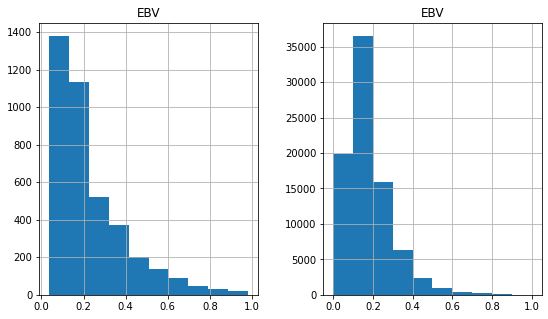

In [744]:
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

df_diff.hist('EBV', ax=axes[0])
df_no_diff.hist('EBV', ax=axes[1])
plt.show()

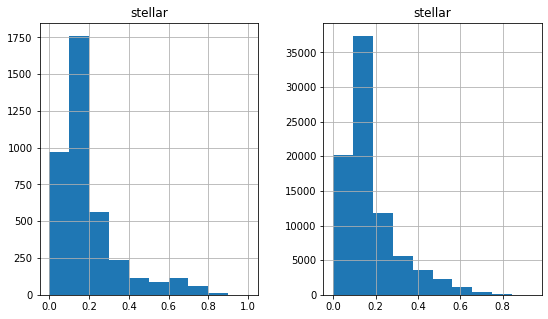

In [745]:
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)


df_diff.hist('stellar', ax=axes[0])
df_no_diff.hist('stellar', ax=axes[1])
plt.show()


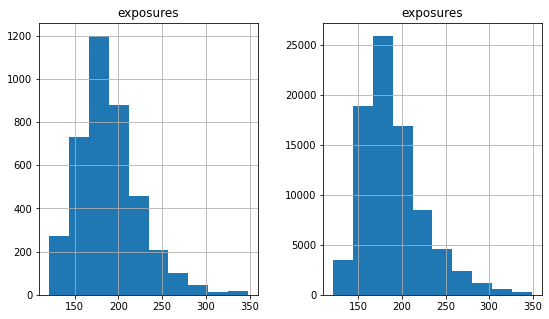

In [746]:
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)


df_diff.hist('exposures', ax=axes[0])
df_no_diff.hist('exposures', ax=axes[1])
plt.show()


In [747]:
ccd_df_diff.exptime = ccd_df_diff.exptime.astype(float)
ccd_df_diff.airmass = ccd_df_diff.airmass.astype(float)
ccd_df_diff.seeing = ccd_df_diff.seeing.astype(float)
ccd_df_diff.ccdskysb = ccd_df_diff.ccdskysb.astype(float)
ccd_df_diff.meansky = ccd_df_diff.meansky.astype(float)

ccd_df_no_diff.exptime = ccd_df_no_diff.exptime.astype(float)
ccd_df_no_diff.airmass = ccd_df_no_diff.airmass.astype(float)
ccd_df_no_diff.seeing = ccd_df_no_diff.seeing.astype(float)
ccd_df_no_diff.ccdskysb = ccd_df_no_diff.ccdskysb.astype(float)
ccd_df_no_diff.meansky = ccd_df_no_diff.meansky.astype(float)


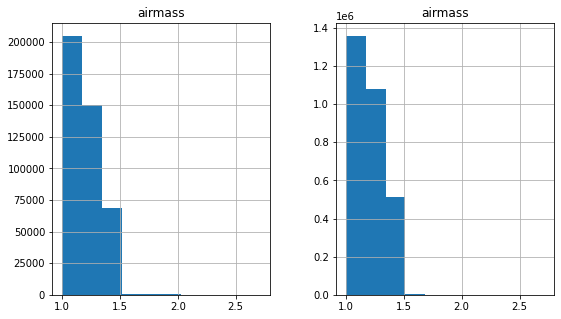

In [748]:
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

ccd_df_diff.hist('airmass', ax=axes[0])
ccd_df_no_diff.hist('airmass', ax=axes[1])
plt.show()

In [749]:
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()

### Attributes in the G-Band

In [750]:
g_df_col_diff = ccd_df_diff[ccd_df_diff['filter'] == 'g']
g_df_col_no_diff = ccd_df_no_diff[ccd_df_no_diff['filter'] == 'g']

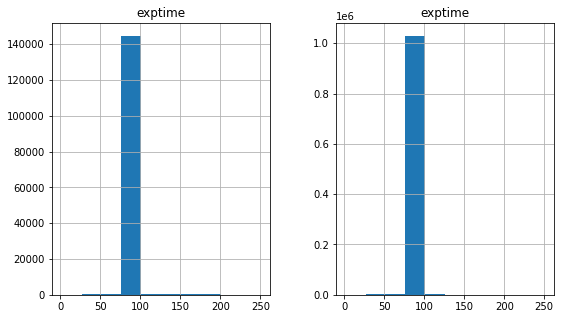

In [751]:
cap_min_diff = g_df_col_diff[(g_df_col_diff['exptime'] <= 300) ]
cap_min_no_diff = g_df_col_no_diff[(g_df_col_no_diff['exptime'] <= 300)]

nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

cap_min_diff.hist('exptime', ax=axes[0] )#, bins=[0,1000])
cap_min_no_diff.hist('exptime', ax=axes[1] )#, bins=[0,1000])
plt.show()

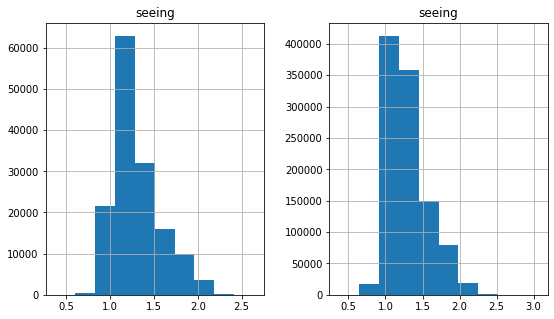

In [752]:
cap_min_diff = g_df_col_diff[(g_df_col_diff['seeing'] < 5) ]
cap_min_no_diff = g_df_col_no_diff[(g_df_col_no_diff['seeing'] < 5)]

nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

cap_min_diff.hist('seeing', ax=axes[0] )#, bins=[0,1000])
cap_min_no_diff.hist('seeing', ax=axes[1] )#, bins=[0,1000])
plt.show()

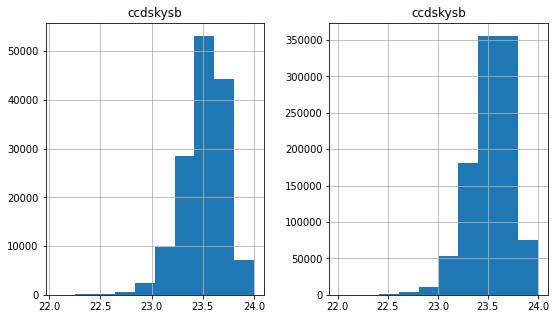

In [753]:
cap_min_diff = g_df_col_diff[(g_df_col_diff['ccdskysb'] > 22) & (g_df_col_diff['ccdskysb'] < 24)]
cap_min_no_diff = g_df_col_no_diff[(g_df_col_no_diff['ccdskysb'] >22) & (g_df_col_no_diff['ccdskysb'] < 24)]

nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

cap_min_diff.hist('ccdskysb', ax=axes[0] )#, bins=[0,1000])
cap_min_no_diff.hist('ccdskysb', ax=axes[1] )#, bins=[0,1000])
plt.show()


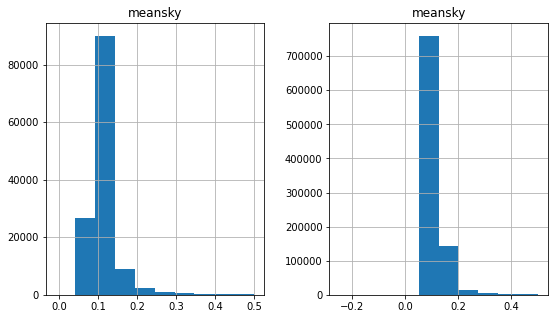

In [754]:
cap_min_diff = g_df_col_diff[(g_df_col_diff['meansky'] < 0.5) & (g_df_col_diff['meansky'] > -3)]
cap_min_no_diff = g_df_col_no_diff[(g_df_col_no_diff['meansky'] < 0.5) & (g_df_col_no_diff['meansky'] > -3)]

nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

cap_min_diff.hist('meansky', ax=axes[0] )#, bins=[0,1000])
cap_min_no_diff.hist('meansky', ax=axes[1] )#, bins=[0,1000])
plt.show()

In [755]:
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()

### Attributes in the R-Band

In [756]:
r_df_col_diff = ccd_df_diff[ccd_df_diff['filter'] == 'r']
r_df_col_no_diff = ccd_df_no_diff[ccd_df_no_diff['filter'] == 'r']


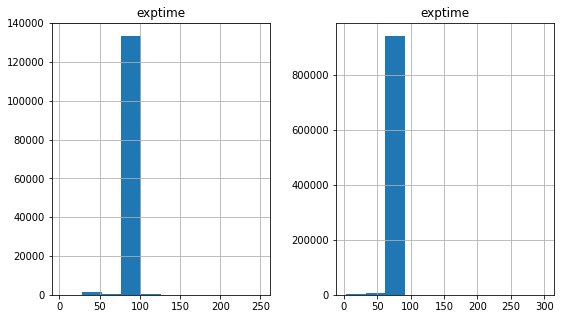

In [757]:
cap_min_diff = r_df_col_diff[(r_df_col_diff['exptime'] <= 300) ]
cap_min_no_diff = r_df_col_no_diff[(r_df_col_no_diff['exptime'] <= 300)]

nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

cap_min_diff.hist('exptime', ax=axes[0] )#, bins=[0,1000])
cap_min_no_diff.hist('exptime', ax=axes[1] )#, bins=[0,1000])
plt.show()

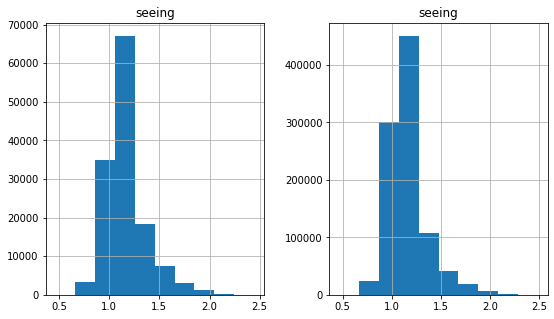

In [758]:
cap_min_diff = r_df_col_diff[(r_df_col_diff['seeing'] < 2.5) ]
cap_min_no_diff = r_df_col_no_diff[(r_df_col_no_diff['seeing'] < 2.5)]

nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

cap_min_diff.hist('seeing', ax=axes[0] )#, bins=[0,1000])
cap_min_no_diff.hist('seeing', ax=axes[1] )#, bins=[0,1000])
plt.show()

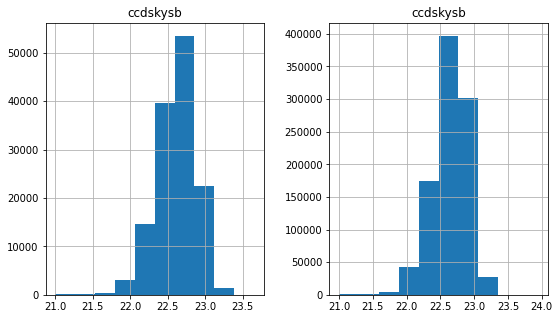

In [759]:
cap_min_diff = r_df_col_diff[(r_df_col_diff['ccdskysb'] > 21) & (r_df_col_diff['ccdskysb'] < 24)]
cap_min_no_diff = r_df_col_no_diff[(r_df_col_no_diff['ccdskysb'] >21) & (r_df_col_no_diff['ccdskysb'] < 24)]

nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

cap_min_diff.hist('ccdskysb', ax=axes[0] )#, bins=[0,1000])
cap_min_no_diff.hist('ccdskysb', ax=axes[1] )#, bins=[0,1000])
plt.show()


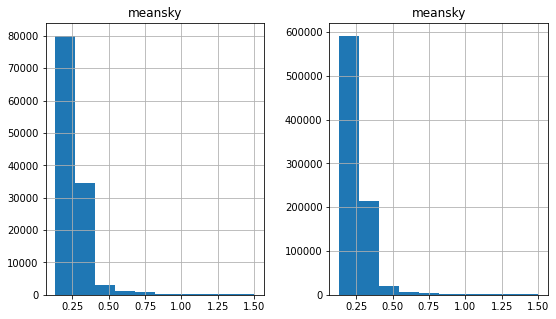

In [760]:
cap_min_diff = r_df_col_diff[(r_df_col_diff['meansky'] < 1.5) & (r_df_col_diff['meansky'] > -3)]
cap_min_no_diff = r_df_col_no_diff[(r_df_col_no_diff['meansky'] < 1.5) & (r_df_col_no_diff['meansky'] > -3)]

nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

cap_min_diff.hist('meansky', ax=axes[0] )#, bins=[0,1000])
cap_min_no_diff.hist('meansky', ax=axes[1] )#, bins=[0,1000])
plt.show()

In [761]:
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()


### Attributes in the Z-Band

In [762]:
z_df_col_diff = ccd_df_diff[ccd_df_diff['filter'] == 'z']
z_df_col_no_diff = ccd_df_no_diff[ccd_df_no_diff['filter'] == 'z']

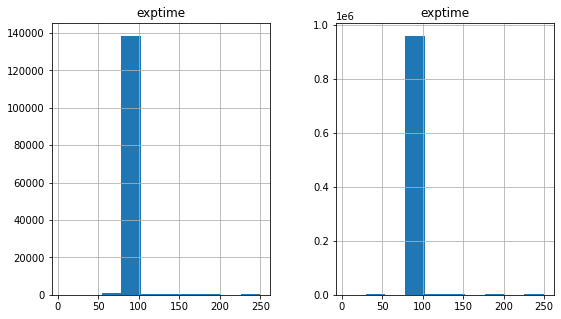

In [763]:
cap_min_diff = z_df_col_diff[(z_df_col_diff['exptime'] <= 300) ]
cap_min_no_diff = z_df_col_no_diff[(z_df_col_no_diff['exptime'] <= 300)]

nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

cap_min_diff.hist('exptime', ax=axes[0] )#, bins=[0,1000])
cap_min_no_diff.hist('exptime', ax=axes[1] )#, bins=[0,1000])
plt.show()

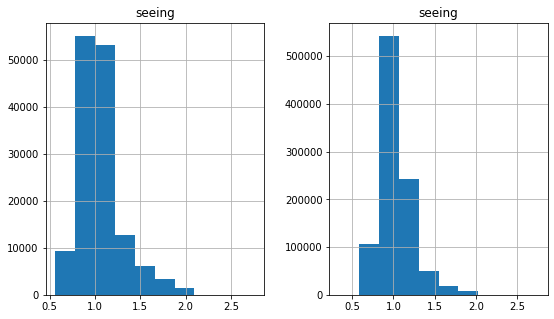

In [764]:
cap_min_diff = z_df_col_diff[(z_df_col_diff['seeing'] < 3) ]
cap_min_no_diff = z_df_col_no_diff[(z_df_col_no_diff['seeing'] < 3)]

nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

cap_min_diff.hist('seeing', ax=axes[0] )#, bins=[0,1000])
cap_min_no_diff.hist('seeing', ax=axes[1] )#, bins=[0,1000])
plt.show()

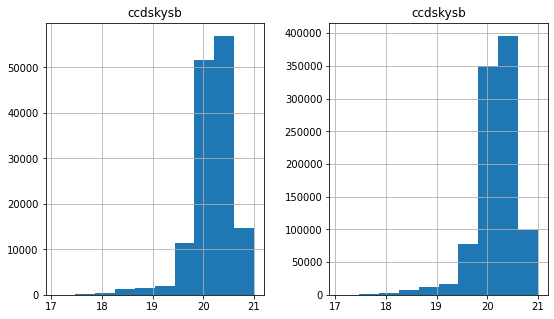

In [765]:
cap_min_diff = z_df_col_diff[(z_df_col_diff['ccdskysb'] > 17) & (z_df_col_diff['ccdskysb'] < 21)]
cap_min_no_diff = z_df_col_no_diff[(z_df_col_no_diff['ccdskysb'] >17) & (z_df_col_no_diff['ccdskysb'] < 21)]

nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

cap_min_diff.hist('ccdskysb', ax=axes[0] )#, bins=[0,1000])
cap_min_no_diff.hist('ccdskysb', ax=axes[1] )#, bins=[0,1000])
plt.show()

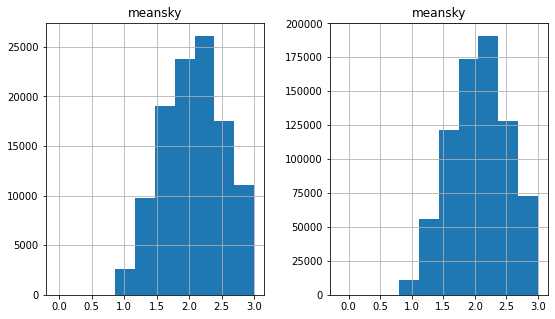

In [766]:
cap_min_diff = z_df_col_diff[(z_df_col_diff['meansky'] < 3) & (z_df_col_diff['meansky'] > -3)]
cap_min_no_diff = z_df_col_no_diff[(z_df_col_no_diff['meansky'] < 3) & (z_df_col_no_diff['meansky'] > -3)]

nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

cap_min_diff.hist('meansky', ax=axes[0] )#, bins=[0,1000])
cap_min_no_diff.hist('meansky', ax=axes[1] )#, bins=[0,1000])
plt.show()


In [767]:

print(f'Percent g-band exposures of all exposures where Linear and Deep Differ: {round(len(g_df_col_diff)/len(ccd_df_diff),3)}%')
print(f'Percent g-band exposures of all exposures where Linear and Deep Agree: {round(len(g_df_col_no_diff)/len(ccd_df_no_diff),3)}%')
print()
print(f'Percent r-band exposures of all exposures where Linear and Deep Differ:: {round(len(r_df_col_diff)/len(ccd_df_diff),3)}%')
print(f'Percent r-band exposures of all exposures where Linear and Deep Agree: {round(len(r_df_col_no_diff)/len(ccd_df_no_diff),3)}%')
print()
print(f'Percent z-band exposures of all exposures where Linear and Deep Differ:: {round(len(z_df_col_diff)/len(ccd_df_diff),3)}%')
print(f'Percent z-band exposures of all exposures where Linear and Deep Agree: {round(len(z_df_col_no_diff)/len(ccd_df_no_diff),3)}%')






Percent g-band exposures of all exposures where Linear and Deep Differ: 0.346%
Percent g-band exposures of all exposures where Linear and Deep Agree: 0.351%

Percent r-band exposures of all exposures where Linear and Deep Differ:: 0.321%
Percent r-band exposures of all exposures where Linear and Deep Agree: 0.321%

Percent z-band exposures of all exposures where Linear and Deep Differ:: 0.334%
Percent z-band exposures of all exposures where Linear and Deep Agree: 0.328%
